In [1]:
import numpy as onp
import jax.numpy as np
from jax import random, grad, vmap, jit
from jax.example_libraries import optimizers
from jax.experimental.ode import odeint
from jax.nn import relu
from jax import config

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Define the neural net
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

In [3]:
# Data generator
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s, 
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u # input sample
        self.y = y # location
        self.s = s # labeled data evaluated at y (solution measurements, BC/IC conditions, etc.)
        
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        s = self.s[idx,:]
        y = self.y[idx,:]
        u = self.u[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs

In [4]:
# Define the model
class PI_DeepONet:
    def __init__(self, branch_layers, trunk_layers):    
        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = MLP(branch_layers, activation=np.tanh)
        self.trunk_init, self.trunk_apply = MLP(trunk_layers, activation=np.tanh)

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3, 
                                                                      decay_steps=1000, 
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        self.itercount = itertools.count()
        
        # Loggers
        self.loss_log = []
        self.loss_operator_log = []
        self.loss_physics_log = []

    # Define DeepONet architecture
    def operator_net(self, params, u, y):
        branch_params, trunk_params = params
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        outputs = np.sum(B * T)
        return outputs
    
    # Define ODE/PDE residual
    def residual_net(self, params, u, y):
        s_y = grad(self.operator_net, argnums = 2)(params, u, y)
        return s_y
    
    # Define operator loss
    def loss_operator(self, params, batch):
        # Fetch data
        # inputs: (u, y), shape = (N, m), (N,1)
        # outputs: s, shape = (N,1)
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.operator_net, (None, 0, 0))(params, u, y)
        # Compute loss
        loss = np.mean((outputs.flatten() - pred.flatten())**2)
        return loss

    # Define physics loss
    def loss_physics(self, params, batch):
        # Fetch data
        # inputs: (u_r, y_r), shape = (NxQ, m), (NxQ,1)
        # outputs: s_r, shape = (NxQ, 1)
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.residual_net, (None, 0, 0))(params, u, y)
        # Compute loss
        loss = np.mean((outputs.flatten() - pred.flatten())**2)
        return loss    
    
    # Define total loss
    def loss(self, params, operator_batch, physics_batch):
        loss_operator = self.loss_operator(params, operator_batch)
        loss_physics = self.loss_physics(params, physics_batch)
        loss = loss_operator + loss_physics
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, operator_batch, physics_batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, operator_batch, physics_batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, operator_dataset, physics_dataset, nIter = 10000):
        # Define the data iterator
        operator_data = iter(operator_dataset)
        physics_data = iter(physics_dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            operator_batch= next(operator_data)
            physics_batch = next(physics_data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, operator_batch, physics_batch)
            
            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute losses
                loss_value = self.loss(params, operator_batch, physics_batch)
                loss_operator_value = self.loss_operator(params, operator_batch)
                loss_physics_value = self.loss_physics(params, physics_batch)

                # Store losses
                self.loss_log.append(loss_value)
                self.loss_operator_log.append(loss_operator_value)
                self.loss_physics_log.append(loss_physics_value)

                # Print losses during training
                pbar.set_postfix({'Loss': loss_value, 
                                  'loss_operator' : loss_operator_value, 
                                  'loss_physics': loss_physics_value})
       
           
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0))(params, U_star, Y_star)
        return s_pred

    @partial(jit, static_argnums=(0,))
    def predict_s_y(self, params, U_star, Y_star):
        s_y_pred = vmap(self.residual_net, (None, 0, 0))(params, U_star, Y_star)
        return s_y_pred

In [5]:
# Length scale of a Gaussian random field (GRF)
length_scale = 0.2

# Define RBF kernel
def RBF(x1, x2, params):
    output_scale, lengthscales = params
    diffs = np.expand_dims(x1 / lengthscales, 1) - \
            np.expand_dims(x2 / lengthscales, 0)
    r2 = np.sum(diffs**2, axis=2)
    return output_scale * np.exp(-0.5 * r2)

# Geneate training data corresponding to one input sample
def generate_one_training_data(key, m=100, P=1):
    # Sample GP prior at a fine grid
    N = 512
    gp_params = (1.0, length_scale)
    jitter = 1e-10
    X = np.linspace(0, 1, N)[:,None]
    K = RBF(X, X, gp_params)
    L = np.linalg.cholesky(K + jitter*np.eye(N))
    gp_sample = np.dot(L, random.normal(key, (N,)))

    # Create a callable interpolation function  
    u_fn = lambda x, t: np.interp(t, X.flatten(), gp_sample)

    # Input sensor locations and measurements
    x = np.linspace(0, 1, m)
    u = vmap(u_fn, in_axes=(None,0))(0.0, x)

    # Output sensor locations and measurements
    y_train = random.uniform(key, (P,)).sort() 
    s_train = odeint(u_fn, 0.0, np.hstack((0.0, y_train)))[1:] # JAX has a bug and always returns s(0), so add a dummy entry to y and return s[1:]

    # Tile inputs
    u_train = np.tile(u, (P,1))

    # training data for the residual
    u_r_train = np.tile(u, (m, 1))
    y_r_train = x
    s_r_train = u

    return u_train, y_train, s_train, u_r_train, y_r_train,  s_r_train

# Geneate test data corresponding to one input sample
def generate_one_test_data(key, m=100, P=100):
    # Sample GP prior at a fine grid
    N = 512
    gp_params = (1.0, length_scale)
    jitter = 1e-10
    X = np.linspace(0, 1, N)[:,None]
    K = RBF(X, X, gp_params)
    L = np.linalg.cholesky(K + jitter*np.eye(N))
    gp_sample = np.dot(L, random.normal(key, (N,)))

    # Create a callable interpolation function  
    u_fn = lambda x, t: np.interp(t, X.flatten(), gp_sample)

    # Input sensor locations and measurements
    x = np.linspace(0, 1, m)
    u = vmap(u_fn, in_axes=(None,0))(0.0, x)

    # Output sensor locations and measurements
    y = np.linspace(0, 1, P)
    s = odeint(u_fn, 0.0, y)

    # Tile inputs
    u = np.tile(u, (P,1))

    return u, y, s 

# Geneate training data corresponding to N input sample
def generate_training_data(key, N, m, P):
    config.update("jax_enable_x64", True)
    keys = random.split(key, N)
    gen_fn = jit(lambda key: generate_one_training_data(key, m, P))
    u_train, y_train, s_train, u_r_train, y_r_train, s_r_train = vmap(gen_fn)(keys)

    u_train = np.float32(u_train.reshape(N * P,-1))
    y_train = np.float32(y_train.reshape(N * P,-1))
    s_train = np.float32(s_train.reshape(N * P,-1))

    u_r_train = np.float32(u_r_train.reshape(N * m,-1))
    y_r_train = np.float32(y_r_train.reshape(N * m,-1))
    s_r_train = np.float32(s_r_train.reshape(N * m,-1))

    config.update("jax_enable_x64", False)
    return u_train, y_train, s_train, u_r_train, y_r_train,  s_r_train

# Geneate test data corresponding to N input sample
def generate_test_data(key, N, m, P):
    config.update("jax_enable_x64", True)
    keys = random.split(key, N)
    gen_fn = jit(lambda key: generate_one_test_data(key, m, P))
    u, y, s = vmap(gen_fn)(keys)
    u = np.float32(u.reshape(N * P,-1))
    y = np.float32(y.reshape(N * P,-1))
    s = np.float32(s.reshape(N * P,-1))

    config.update("jax_enable_x64", False)
    return u, y, s

# Compute relative l2 error over N test samples.
def compute_error(key, m, P):
    # Generate one test sample
    u_test, y_test, s_test = generate_test_data(key, 1, m, P)
    
    # Predict the solution and the residual
    s_pred = model.predict_s(params, u_test, y_test)[:,None]
    s_y_pred = model.predict_s_y(params, u_test, y_test)

    # Compute relative l2 error
    error_s = np.linalg.norm(s_test - s_pred) / np.linalg.norm(s_test) 
    error_u = np.linalg.norm(u_test[::P_test].flatten()[:,None] - s_y_pred) / np.linalg.norm(u_test[::P_test].flatten()[:,None]) 

    return error_s, error_u

In [6]:
N_train = 10000 # number of input samples
m = 100 # number of input sensors
P_train = 1   # number of output sensors
key_train = random.PRNGKey(0) # use different key for generating training data and test data 
u_train, y_train, s_train, u_r_train, y_r_train, s_r_train = generate_training_data(key_train, N_train, m, P_train)

# If solve the foward problem
# y_train = np.zeros((N_train, 1))
# s_train = np.zeros((N_train, 1))

In [7]:
# Initialize model
branch_layers = [m, 50, 50, 50, 50, 50]
trunk_layers =  [1, 50, 50, 50, 50, 50]
model = PI_DeepONet(branch_layers, trunk_layers)

In [8]:
# Create data set
batch_size = 10000
operator_dataset = DataGenerator(u_train, y_train, s_train, batch_size)
physics_dataset = DataGenerator(u_r_train, y_r_train, s_r_train, batch_size)

In [9]:
# Train
model.train(operator_dataset, physics_dataset, nIter=40000)

100%|██████████| 40000/40000 [02:07<00:00, 313.53it/s, Loss=3.4403616e-05, loss_operator=1.0731097e-06, loss_physics=3.3330507e-05] 


In [10]:
# Compute test error
N_test = 1000 # number of input samples 
P_test = m   # number of sensors 
key_test = random.PRNGKey(12345) # A different key 
keys_test = random.split(key_test, N_test)

# Predict
params = model.get_params(model.opt_state)

# Compute errors over test dataset
error_s, error_u = vmap(compute_error, (0, None, None))(keys_test, m, P_test) 

print('mean of relative L2 error of s: {:.2e}'.format(error_s.mean()))
print('mean of relative L2 error of u: {:.2e}'.format(error_u.mean()))

print('std of relative L2 error of s: {:.2e}'.format(error_s.std()))
print('std L2 error of u: {:.2e}'.format(error_u.std()))

mean of relative L2 error of s: 4.92e-03
mean of relative L2 error of u: 7.24e-03
std of relative L2 error of s: 3.85e-03
std L2 error of u: 3.83e-03


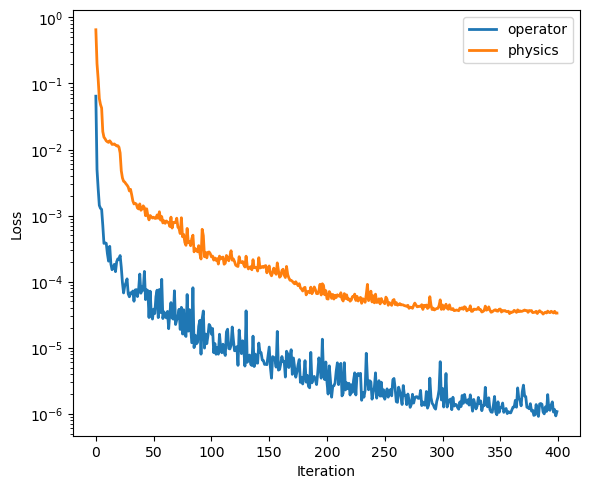

In [11]:
#Plot for loss function
plt.figure(figsize = (6,5))
# plt.plot(model.loss_log, lw=2)
plt.plot(model.loss_operator_log, lw=2, label='operator')
plt.plot(model.loss_physics_log, lw=2, label='physics')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# Generate test data
N_test = 100
P_test = m
key_test = random.PRNGKey(12345)
keys_test = random.split(key_test, N_test)

u_test, y_test, s_test =  generate_test_data(key_test, N_test, m, m)

params = model.get_params(model.opt_state)

# Model predictions
s_pred = model.predict_s(params, u_test, y_test)[:,None]
s_y_pred = model.predict_s_y(params, u_test, y_test)

error_u: 3.047e-03
error_s: 5.637e-03


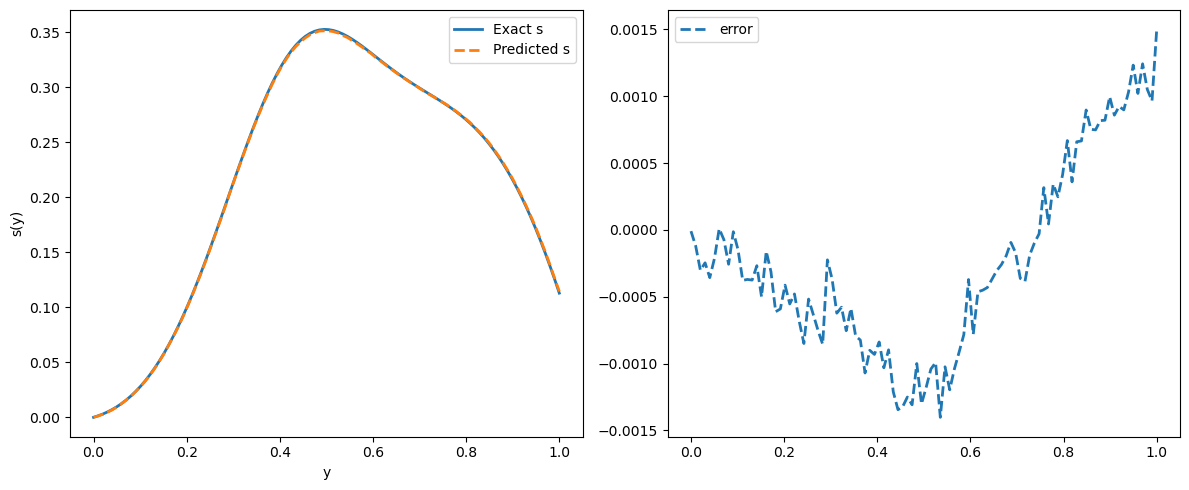

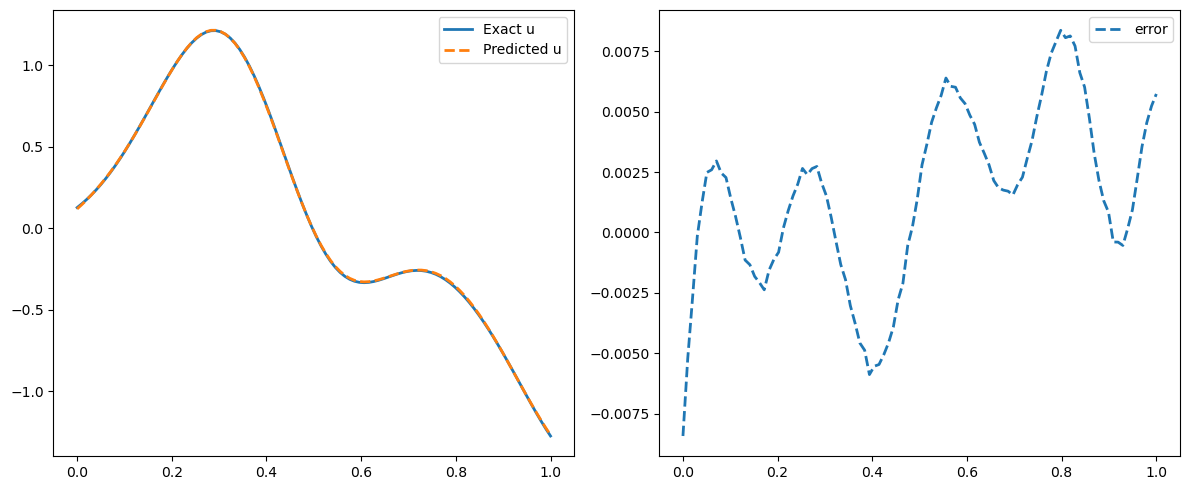

In [13]:
# Plot for one generated data
# idx = onp.random.randint(N_test) # random visualizations
idx=0
index = np.arange(idx * P_test,(idx + 1) * P_test)

# Compute the relative l2 error for one input sample 
error_u = np.linalg.norm(s_test[index, :] - s_pred[index, :], 2) / np.linalg.norm(s_test[index, :], 2) 
error_s = np.linalg.norm(u_test[::P_test][idx].flatten()[:,None] - s_y_pred[index, :], 2) / np.linalg.norm(u_test[::P_test][idx].flatten()[:,None], 2) 

print("error_u: {:.3e}".format(error_u))
print("error_s: {:.3e}".format(error_s))

# Visualizations
# Predicted solution s(y)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(y_test[index, :], s_test[index, :], label='Exact s', lw=2)
plt.plot(y_test[index, :], s_pred[index, :], '--', label='Predicted s', lw=2)
plt.xlabel('y')
plt.ylabel('s(y)')
plt.tight_layout()
plt.legend()

plt.subplot(1,2,2)
plt.plot(y_test[index, :], s_pred[index, :] - s_test[index, :], '--', lw=2, label='error')
plt.tight_layout()
plt.legend()
plt.show()

# Predicted residual u(x)
fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(y_test[index, :], u_test[::P_test][idx], label='Exact u', lw=2)
plt.plot(y_test[index, :], s_y_pred[index,:], '--', label='Predicted u', lw=2)
plt.legend()
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(y_test[index, :], s_y_pred[index,:].flatten() - u_test[::P_test][idx] , '--', label='error', lw=2)
plt.legend()
plt.tight_layout()
plt.show()